In [ ]:
%%shell
jupyter nbconvert --to html /content/Hito3ESTE_SI_draft5.ipynb --no-input --no-prompt

[NbConvertApp] Converting notebook /content/Hito3ESTE_SI_draft5.ipynb to html
[NbConvertApp] Writing 1237481 bytes to /content/Hito3ESTE_SI_draft5.html


# **Informe Grupo 6 Sección Hito 1 - "Steam Videogames Analysis"**

**Integrantes del Grupo:** Cristóbal Braga, Isabel Marx, Iván Salas, Manuel Ortiz y Sofia Medina

### **Introducción**

En un mundo donde la tecnología y la innovación están en constante evolución, la industria de los videojuegos emerge como uno de los sectores más dinámicos y prometedores. Según el informe Gaming & Esports Report 2023 de YouGov, un 31% de la población mundial se dedica activamente a jugar videojuegos en diversas plataformas, ya sea en PC, consolas o dispositivos móviles, durante una semana típica. Este dato por sí solo pone de manifiesto la popularidad y el alcance de esta forma de entretenimiento. Dentro de este panorama, Steam, la plataforma de distribución digital de videojuegos desarrollada por Valve Corporation, juega un papel fundamental. Lo que comenzó en septiembre de 2003 como un medio para que Valve proporcionara actualizaciones automáticas a sus propios juegos ha evolucionado a lo largo de los años hasta convertirse en una plataforma donde coexisten desde desarrolladores independientes hasta grandes corporaciones de software, lo que brinda a los jugadores una variedad sorprendente de opciones. Este fenómeno plantea una pregunta crucial: ¿Qué hace que un juego sea exitoso en un mercado tan diverso y competitivo? El estudio del comportamiento de plataformas como Steam proporciona información sobre las tendencias y las estrategias que pueden llevar a un juego al éxito en este entorno digital en constante expansión.

In [1]:
# PREPROCESAMIENTO DEL DATASET
# standard library imports
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive/')
df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

def remove_non_english(df):
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()

    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]

    # remove english column, now redundant
    df = df.drop('english', axis=1)

    return df

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews

    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])

    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]

    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)

        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

    # repeat for genre column names (get_unique used to find unique genre names,
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])

    # only keeping 'main' genres similar to steam store
    gen_cols = ['Action','Adventure','Casual','Indie','Massively Multiplayer',
                'RPG','Racing','Simulation','Sports','Strategy']

    gen_col_names = []

    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)

        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)

    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()

    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])

    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    # [optional] remove 'genres column'
    #df = df.drop('genres',axis=1)

    return df

def pre_process(df):
    # keep english only
    df = remove_non_english(df)

    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()

    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)

    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)

    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)

    return df

# Process data
data = pre_process(df_steam)
data.head()

Mounted at /content/drive/


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,...,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,124534,3339,...,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,3318,633,...,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,3416,398,...,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1273,267,...,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,5250,288,...,1,0,0,0,0,0,0,0,0,0



### **Análisis Exploratorio de Datos**
Con respecto a la motivación mencionada anteriormente, se ha seleccionado el conjunto de datos “Steam Store Games” de la página web Kaggle. Este conjunto de datos contiene información recopilada en mayo de 2019 sobre videojuegos de la plataforma Steam y está compuesto por 6 archivos:

*   steam.csv
*   steam_description_data.csv
*   steam_media_data.csv
*   steam_requirements_data.csv
*   steam_support_info.csv
*   steamspy_tag_data.csv

Para los propósitos iniciales del proyecto, se utilizará el archivo principal, steam.csv, aunque no se descarta la posibilidad de utilizar datos de otros archivos según los requisitos futuros del proyecto. A continuación, se presenta un resumen del análisis exploratorio inicial de los datos contenidos en steam.csv, que consta de 18 columnas diferentes.


  1. “appid” (int), identificador (llave) de cada juego, los valores van desde 10 a 1.069.460, también se comprueba que efectivamente los id sean únicos, al comparar el largo de los valores únicos de la columna con el largo original.
  
  2. “name” (char), nombre de cada juego, en este atributo se puede notar que hay 41 names repetidos, siendo “Dark Matter” el nombre con más repeticiones (hay tres juegos de distintos estudios con el nombre “Dark Matter”)

  3. “release_date” (char), fecha de lanzamiento de cada juego, en formato YYYY-MM-DD. Es importante notar que el 75% de las tuplas (del primer al último cuartil) están concentradas desde el 2016 al 2019, es decir los últimos tres años del dataset contienen la mayor información.

  4. “english” (int), variable binaria que indica si un juego está en inglés o no, en síntesis un 98,11% de los juegos del dataset están en inglés y solo un 1,88% está en otro idioma.

  5. “developer” (char), nombre(s) del desarrollador de cada juego. Hay 17.112 distintos, lo que sugiere una gran diversidad de desarrolladores. De estos, los 5 que más se repiten son: Choice of Games (94), KOEI TECMO GAMES CO., LTD. (72), Ripknot Systems (62), Laush Dmitriy Sergeevich (51) y Nikita “Ghost_RUS” (50).

  6. “publisher” (char), como en la columna anterior, hay una gran cantidad de publishers distintos. Hay 14.354 publishers únicos y los que más se repiten son: Big Fish Games (212), Strategy First (136), Ubisoft (111), THQ Nordic (98), Square Enix (97).

  7. “platforms” (char), plataformas en la/s que corre cada juego. De los 7 distintos posibles valores de tuplas que hay en esta columna Windows está presente en 4 alternativas, lo que implica que de los 27.075
  juegos distintos 27.070 funcionan con Windows, es decir el 99,98% de los juegos corren en Windows.

  8. “required_age” (int), edad mínima para jugar cada juego. Hay 6 valores distintos (0,3,7,12,16 y 18). La mayoría (97,79%) de los juegos tienen como edad mínima 0.
  
  9. “categories” (char), categorías de cada juego, contiene 29 categorías distintas, siendo “Single-player” la más popular con 25.678 menciones.

  10. “genres” (char), géneros de cada juego y hay 29 distintos. El más popular es “Indie” con 19.421 menciones, es decir el 71,73% de los juegos son mencionados como “Indie”. Cada juego puede tener más de un género a la vez.

  11. “steamspy_tags” (char), es similar a genres pero votada por la comunidad. Aquí hay más etiquetas que en la columna anterior (339 distintas), sin embargo “Indie” sigue siendo la mención más frecuente, esta vez en el 60% de los juegos. Las 5 más frecuentes además de Indie son Action, Casual, Adventure y
  Strategy.

  12. “achievements” (int), cantidad de logros de cada juego. El máximo es 9.821, sin embargo la mediana es igual a 7, y el tercer cuartil igual a 23, es decir, la mayoría de los juegos tienen pocos o ningún logro
  (11.864 juegos con 0 logros).

  13. “positive_ratings” (int), cantidad de calificaciones positivas de cada juego. En esta columna se puede notar que el 75% están entre 0 y 126 positive reviews, pero el máximo es 2.644.404, lo cual implica que juegos con un alto número de valoraciones son casos extremos. La media de calificaciones positivas es 1.000,559 y su desviación estándar 18.988,72 .

  14. “negative_ratings” (int), cantidad de calificaciones negativas de cada juego. Similar a la anterior, la mayoría de los juegos tienen pocas reviews, teniendo el 75% entre 0 y 42 negative reviews. El valor máximo de negative reviews que tiene un juego es 487,076. La media de calificaciones negativas es
  211,0271 y su desviación estándar 4.284,939.

  15. “average_playtime” (int), cantidad de horas jugadas promedio de cada juego. Solo 6.170 juegos tienen valor distinto de 0, es decir, el 22,78%, y por ende el 77,21% de los juegos tienen tiempo promedio igual a 0.

  16. “median_playtime” (int), tiempo medio de juego. En este caso solo hay 6.170 juegos con un tiempo distinto de 0.

  17. “owners” (char), rangos de cantidad de personas que poseen cada juego. Para este análisis se tomó el punto medio del intervalo que se presenta en el dataset en la columna, de esa forma se tiene que el 75% tienen un número de owners entre 10.000 y 35.000.

  18. “price” (double con 2 decimales), precio de cada juego en su salida. El 75% de los juegos tienen un valor entre 0 y 7.190 GBP, además hay 2.560 juegos gratis.


Habiendo resumido las columnas, se presenta a continuación cómo se correlacionan entre sí. Las correlaciones entre atributos más destacadas son positivas y se dan entre los siguientes atributos: positive_ratings/negative_ratings, average_playtime/median_playtime, owners_midpoint/positive_rankig y owners_midpoint/negative ratings.

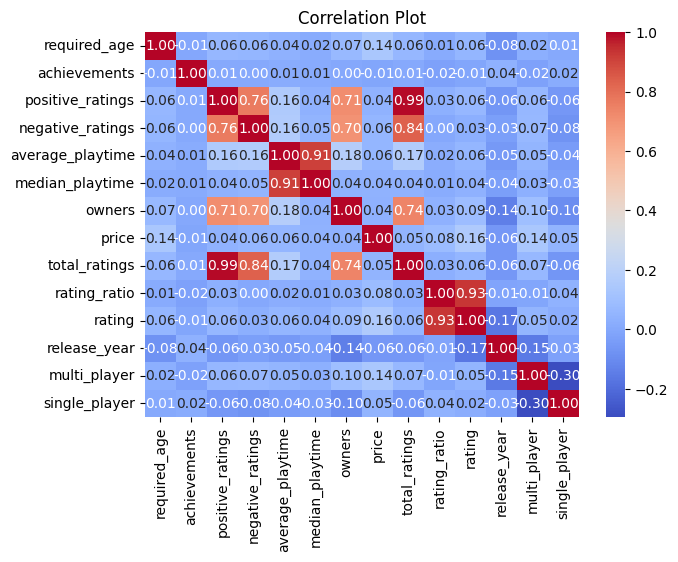

In [2]:
# List of columns to exclude and convert to lowercase
gen_cols = ['appid','action','adventure','casual','indie','massively_multiplayer','rpg','racing','simulation','sports','strategy']

# Filter numeric columns in the DataFrame, excluding the specified columns
columnas_numericas = data.select_dtypes(include=[np.number]).drop(columns=gen_cols)

# Calculate the correlation matrix
matriz_correlacion = columnas_numericas.corr()

# Create a correlation plot using Seaborn
plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Plot")
plt.show()


### **Gráficos**

A continuación se presenta la sección de gráficos del informe, en el cual se han graficado variables interesantes para los propositos del proyecto.

En la siguiente gráfica se observa que alrededor de 17.500 juegos tienen 0 owners, es decir hay muchos juegos con pocos owners y pocos juegos con muchos owners.

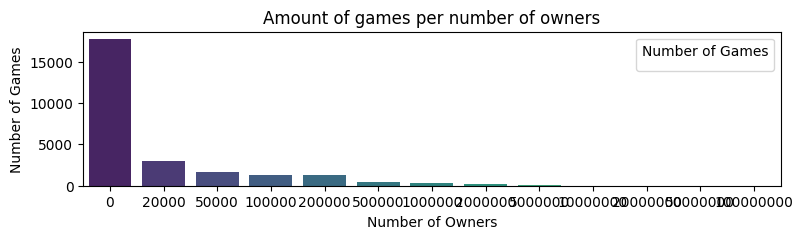

In [6]:
# Grafica Amount of games per number of owners
# Group and aggregate the data
agg_own = data.groupby('owners').size().reset_index(name='total_count')
agg_own = agg_own.sort_values(by='total_count', ascending=True)

# Create the plot
plt.figure(figsize=(9, 2))
ax = sns.barplot(x='owners', y='total_count', data=agg_own, palette="viridis")
plt.title("Amount of games per number of owners")
plt.xlabel("Number of Owners")
plt.ylabel("Number of Games")
plt.legend([], title="Number of Games")
plt.show()

Se observa que los últimos años es cuando se lanzaron más juegos, siendo 2018 el año en que más se lanzaron, con más de 8.000.

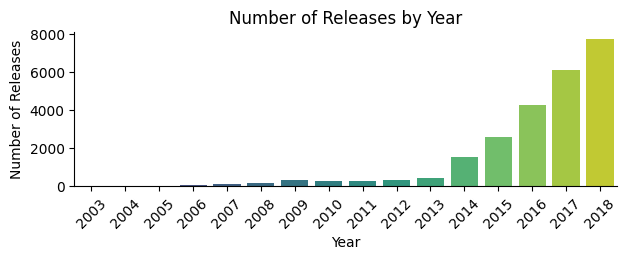

In [7]:
data2 = data[(data['release_year'] >= 2003) & (data['release_year'] <= 2018)]
years = sorted(data2['release_year'].unique())
release_counts = data2['release_year'].value_counts().sort_index()

plt.figure(figsize=(7, 2))
ax = sns.barplot(x=years, y=release_counts, palette='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of Releases by Year')
plt.xticks(rotation=45)
sns.despine()
plt.show()

En la siguiente gráfica se puede apreciar las valoraciones positivas y negativas de un subset de juegos famosos.

<Figure size 600x400 with 0 Axes>

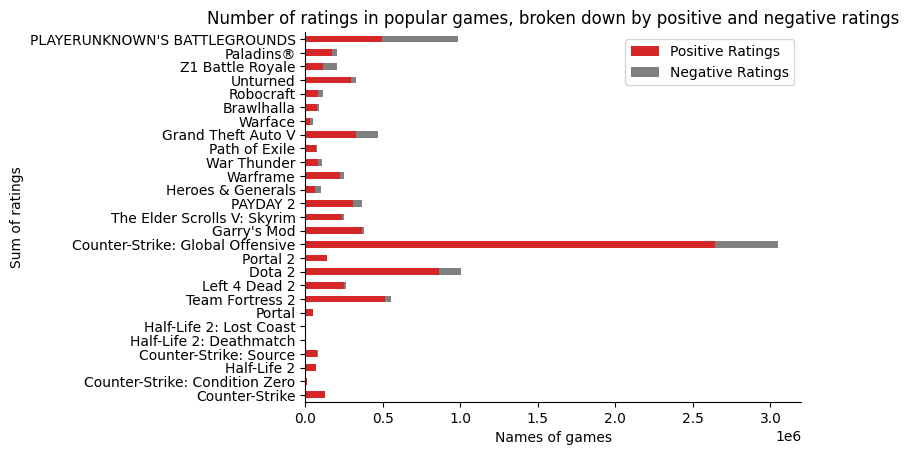

In [8]:
# Calculate 'owners_n' as unique values sorted
owners_n = sorted(data['owners'].unique())

# Filter 'steam' to include rows where 'owners_mid_bound' is greater than or equal to the 10th value in 'owners_n'
agg_own = data[data['owners'] >= owners_n[9]]

ratings = agg_own['positive_ratings'] + agg_own['negative_ratings']

df1 = pd.DataFrame({
    'Name': agg_own['name'],
    'Positive Ratings': agg_own['positive_ratings'],
    'Negative Ratings': agg_own['negative_ratings'],
    'Ratings': ratings,
    'Owners': agg_own['owners'],
    'Price': agg_own['price']
})

owners_df = pd.DataFrame(zip(df1['Name'], df1['Positive Ratings'], df1['Negative Ratings']),
                         columns=['Name', 'Positive Ratings', 'Negative Ratings'])

plt.figure(figsize=(6, 4))
ax = df1.plot(x='Name', y=['Positive Ratings', 'Negative Ratings'], kind='barh', stacked=True, color=['tab:red', 'gray'])

ax.set_ylabel('Sum of ratings')
ax.set_xlabel('Names of games')
ax.set_title('Number of ratings in popular games, broken down by positive and negative ratings')
sns.despine()
plt.show()

Del subset de juegos populares escogidos se presenta el precio en el eje X, y el nombre del juego en el eje y, mientras que el largo de la barra representa el precio de cada juego. (Ver anexo Hito.ipynb en el Github)

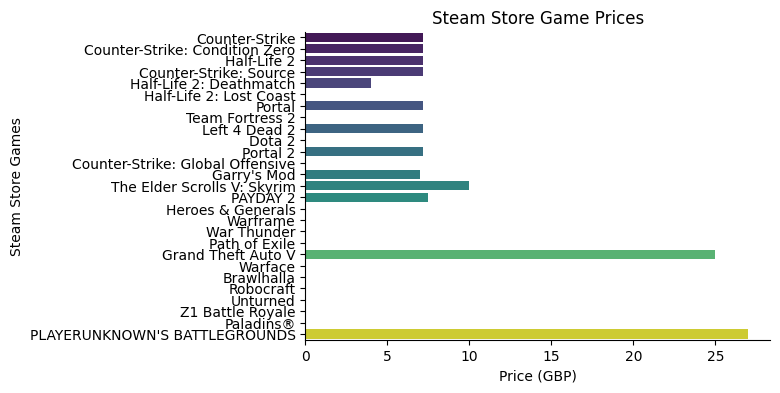

In [9]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Price', y='Name', data=df1, palette='viridis')

ax.set_xlabel('Price (GBP)')
ax.set_ylabel('Steam Store Games')
ax.set_title('Steam Store Game Prices')
plt.xticks(rotation=0)  # Do not rotate x-axis labels
sns.despine()
plt.show()

En la siguiente gráfica se muestran las categorias de juegos más populares.

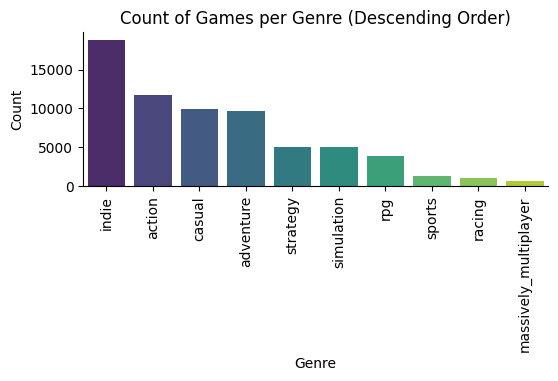

In [ ]:
gen_cols = [
    'action',
    'adventure',
    'casual',
    'indie',
    'massively_multiplayer',
    'rpg',
    'racing',
    'simulation',
    'sports',
    'strategy'
]

# Subset the DataFrame to include only the binary genre columns
genre_data = data[gen_cols]

# Calculate the count of games for each genre
genre_counts = genre_data.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']

# Sort the DataFrame by Count in descending order
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(6, 2))
ax = sns.barplot(x='Genre', y='Count', data=genre_counts, palette='viridis')

ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Count of Games per Genre (Descending Order)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()
plt.show()

### **Preguntas y problemas**

En base al análisis exploratorio de los datos hecho previamente se definen los siguientes problemas y preguntas a resolver utilizando este dataset: ¿Qué es lo que hace que un juego sea bueno?, ¿Cuál es el atributo más importante que define a un juego bueno? ¿su positive/negative ratio, su ganancia, su número de jugadores o su tiempo de juego? (esto nos podría generar un problema con el fenómeno del "review bombing") ¿Hay algún patrón que identifique a los mejores juegos? ¿Hay algún género que sea más exitoso que otros, hay una trama en común en los juegos exitosos?, ¿Hay algún/os atributo/s que permitan predecir si un juego será exitoso o no?

En base a las preguntas anteriores, ¿Se puede hacer un modelo que prediga si un juego con ciertas características será exitoso o no? ¿Con qué certeza se podría hacer esta predicción?

Para determinar qué hace que un juego sea bueno, se puede hacer un análisis de correlación entre las métricas de éxito de un juego, como el positive/negative ratio, ganancia, número de jugadores y tiempo de juego, y las calificaciones o reseñas de los usuarios. Un modelo de regresión podría ser útil para identificar el atributo más influyente en la calidad del juego. Para identificar patrones en los mejores juegos, se pueden utilizar técnicas de clustering para agrupar juegos en categorías similares en función de atributos como género, trama, y otras características relevantes. Posteriormente, se podría realizar un análisis comparativo entre los clusters para identificar tendencias comunes en los juegos exitosos.

Se intentará hacer un modelo de machine learning para predecir si un juego será exitoso o no en función de sus características. Para esto, primero, se tendrá que definir "éxito" (por ejemplo, basado en reseñas, número de jugadores, o ganancias). Luego, podrían usar algoritmos de clasificación, junto con atributos como género, precio, desarrollador, entre otros, para entrenar el modelo. La certeza de la predicción dependerá de la calidad de los datos y la elección adecuada del algoritmo, y se puede evaluar mediante técnicas como la validación cruzada. Contestar estas preguntas puede ser útil para desarrolladores que deseen ingresar al mercado de los juegos digitales, ya que les proporcionaría información valiosa sobre qué características son más relevantes para el éxito de un juego. Esto les permitiría tomar decisiones más informadas en el desarrollo y promoción de sus juegos, maximizando sus posibilidades de éxito en el mercado.

Link al [GitHub](https://github.com/Newtonlml/Steam_Data_Analysis-) del proyecto incluyendo los códigos. Aportes de los integrantes del grupo: Cristóbal Braga: Preguntas y Problemas , Iván Salas: EDA, Sofia Medina: Introducción, Manuel Ortiz: EDA e Isabel Marx: Gráficas.

# **Informe Grupo 6 Sección Hito 2 - "Steam Videogames Analysis"**


In [10]:
# Imports

import itertools
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Data
#df_steam = pd.read_csv('/content/steam.csv')

from google.colab import drive
drive.mount('/content/drive/')
df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Nuevo Pre-procesamiento

Se aplica un preprocesamiento adicional sobre los datos, con el fin de transformar y seleccionar características, además de un limpieza del dataset.
- Se eliminan las filas duplicadas.
- Se crea una nueva columna que representa la suma de los ratings negativos y positivos de cada juego.
- Se crean columnas adicionales basadas en positive y negative ratings, achievements y average playtime, asignando valores según el intervalo en el que se encuentran.
- Se crean columnas que contienen información sobre los owners de cada juego.
- La columna release_date se descompone en columnas separadas de mes y año para permitir un análisis temporal más detallado.
- Las columnas de platforms, categories, genres y steamspy_tags se desglosan en columnas binarias para indicar la presencia o ausencia de cada categoría en un juego.
- Aplicación de SelectKBest: Se eligen las columnas que se consideran variables objetivo, que podrían influir en el éxito de un juego, y se separan del resto del conjunto de datos. Se utiliza el modelo SelectKBest para seleccionar las 10 mejores variables que podrían tener mayor importancia en la clasificación del éxito de un juego. Se varía la variable objetivo en cada iteración. Se seleccionan las variables binarias que se repiten 3 o más veces en la selección.
Se crean variables que representan el número de veces que un developer o un publisher se repiten en distintos juegos, y se asignan clases para intervalos de estos conteos.
- Segunda aplicación de SelectKBest: Se realiza otra selección de características con SelectKBest, sobre todas las variables no relacionadas con el objetivo de éxito de un juego. Se comparan los resultados con cada posible variable objetivo, y se seleccionan las que se repiten 4 o más veces.
Finalmente, se normalizan los datos utilizando MinMaxScaler para asegurar que todas las variables tengan la misma escala y evitar sesgos.
- La tabla resultante de este proceso consta de 27075 filas y 14 columnas

In [11]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews

    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def pre_process(df):
    # keep both bounds of owners column, as integers
    df['owners_lower'] = df_steam['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    df['owners_upper'] = df_steam['owners'].str.split('-').apply(lambda x: x[1]).astype(int)

    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)

    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    df['release_month'] = df['release_date'].apply(lambda x: x.month)
    df.drop(['release_date'], axis=1, inplace=True)

    # process genres, categories and steamspy_tag columns
    column_singular = {'platforms':'platform',
                        'categories':'category',
                        'genres':'genre',
                        'steamspy_tags':'tag'}
    df_set = pd.DataFrame()
    for i in range(len(column_singular)):
        supersets = list(column_singular.keys())[i]
        superset = list(column_singular.values())[i]
        unique_subsets = [subset for subset in sorted(list(set(';'.join(df[supersets].unique()).split(';'))))]
        cols = [superset + ': ' + subset for subset in unique_subsets]
        df_set = pd.concat([df_set, pd.DataFrame(columns = cols)], axis=1)
        for col, subset in enumerate(unique_subsets):
            df_set[cols[col]] = df[supersets].str.contains(subset).replace({False: 0, True: 1})

    df = pd.concat([df, df_set], axis=1)
    drop = list(column_singular.keys())
    drop.append('owners')
    df.drop(columns=drop, axis=1, inplace=True)
    return df

In [12]:
df = pre_process(df_steam)

In [13]:
def pre_process1(df):
  df = df.copy()
  df['rating_grouped'] = pd.cut(df['rating'], range(0,120,10), labels=False, retbins=True, right=False)[0]
  df['rating_ratio_grouped'] = pd.cut(df['rating_ratio'], [val/100 for val in range(0,120,10)], labels=False, retbins=True, right=False)[0]
  return df

In [14]:
df = pre_process1(df)

In [15]:
v_obj = ['achievements','positive_ratings','negative_ratings','average_playtime','median_playtime','owners_lower','owners_upper','total_ratings','rating_ratio_grouped','rating_grouped']
v_cat = ['appid','name','release_month','english', 'developer', 'publisher', 'required_age', 'price', 'release_year','rating_ratio','rating']


In [16]:
def pre_process2(df, v_obj, v_cat):
    # Variables platforms, categories y tags desacopladas
    X = df.copy().drop(v_obj+v_cat,axis=1)
    # Para cada variable posiblemente relacionada a la variable objetivo, se seleccionan
    # las 20 mejores según SelectKBest.
    atr = []
    for i, var_obj in enumerate(v_obj):
      y = df.copy()[var_obj]
      X_fit = SelectKBest(chi2, k=10).fit(X, y)  # original con 10
      cols_idxs = X_fit.get_support(indices=True)
      atr = atr + list(X.columns[cols_idxs])
    return(X, atr)

In [17]:
X, atr = pre_process2(df, v_obj, v_cat)

In [18]:
def pre_process3(atr, df, X, v_obj, v_cat):
    n_inst_atr = {element:atr.count(element) for element in set(atr) if atr.count(element) >= 3} # original con 3 o 4
    n_inst_atr = dict(sorted(n_inst_atr.items()))
    data0 = pd.concat([df[v_obj+v_cat], X[n_inst_atr.keys()]],axis=1).copy()
    # DataFrame con las 22 variables principales y 11 variables extraídas de las variables agrupadas.
    v_obj = ['achievements','positive_ratings','negative_ratings','average_playtime','median_playtime','owners_lower','owners_upper','total_ratings','rating_ratio_grouped','rating_grouped']
    v_cat = ['appid','name','release_month','english', 'developer', 'publisher', 'required_age', 'price', 'release_year','rating_ratio','rating']
    data = data0.copy()
    return(n_inst_atr, data)

In [19]:
n_inst_atr, data = pre_process3(atr, df, X, v_obj, v_cat)

In [20]:
data[sorted(v_obj+v_cat)][data[v_obj+v_cat].columns[0:]].columns

Index(['achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners_lower', 'owners_upper',
       'total_ratings', 'rating_ratio_grouped', 'rating_grouped', 'appid',
       'name', 'release_month', 'english', 'developer', 'publisher',
       'required_age', 'price', 'release_year', 'rating_ratio', 'rating'],
      dtype='object')

In [21]:
def pre_process4(data):
    data = data.copy()
    data['developer_count'] = data['developer'].map(data['developer'].value_counts())
    data['temp0'] = data['developer_count']

    data['publisher_count'] = data['publisher'].map(data['publisher'].value_counts())
    data['temp1'] = data['publisher_count']
    return data

In [22]:
data = pre_process4(data)

In [23]:
def pre_process5(data):
  intervals = range(0,110,10)
  for i in range(10):
    data.loc[(data["temp0"] >= intervals[i]) & (data["temp0"] < intervals[i+1]), "developer_count"] = i

  intervals = range(0,240,20)
  for i in range(11):
    data.loc[(data["temp1"] >= intervals[i]) & (data["temp1"] < intervals[i+1]), "publisher_count"] = i

  intervals = range(0,12000,1000)
  for i in range(11):
    data.loc[(data["achievements"] >= intervals[i]) & (data["achievements"] < intervals[i+1]), "achievements_count"] = i

  intervals = range(0,1000000,50000)
  for i in range(18):
    data.loc[(data["positive_ratings"] >= intervals[i]) & (data["positive_ratings"] < intervals[i+1]), "positive_ratings_count"] = i

  data.loc[(data["positive_ratings"] >= 900000), "positive_ratings_count"] = i

  intervals = range(0,510000,2000)
  for i in range(250):
    data.loc[(data["negative_ratings"] >= intervals[i]) & (data["negative_ratings"] < intervals[i+1]), "negative_ratings_count"] = i

  intervals = range(0,210000,1000)
  for i in range(209):
    data.loc[(data["average_playtime"] >= intervals[i]) & (data["average_playtime"] < intervals[i+1]), "average_playtime_count"] = i
  return data

In [24]:
data = pre_process5(data)

In [25]:
data.drop(['name','appid','developer','publisher','temp0','temp1','achievements',
           'positive_ratings','negative_ratings','average_playtime',
           'median_playtime','owners_upper','total_ratings','rating_grouped'],axis=1,inplace=True)

In [26]:
data

,owners_lower,rating_ratio_grouped,release_month,english,required_age,price,release_year,rating_ratio,rating,category: Mods,...,tag: Gothic,tag: Inventory Management,tag: Lara Croft,tag: Open World,developer_count,publisher_count,achievements_count,positive_ratings_count,negative_ratings_count,average_playtime_count
0,10000000,9,11,1,0,7.19,2000,0.973888,95.975678,0,...,0,0,0,0,2,1,0.0,2.0,1.0,17.0
1,5000000,8,4,1,0,3.99,1999,0.839787,80.508259,0,...,0,0,0,0,2,1,0.0,0.0,0.0,0.0
2,5000000,8,5,1,0,3.99,2003,0.895648,85.823915,0,...,0,0,0,0,2,1,0.0,0.0,0.0,0.0
3,5000000,8,6,1,0,3.99,2001,0.826623,78.126542,0,...,0,0,0,0,2,1,0.0,0.0,0.0,0.0
4,5000000,9,11,1,0,3.99,1999,0.947996,91.260480,0,...,0,0,0,0,0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,10,4,1,0,2.09,2019,1.000000,67.059371,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
27071,0,8,4,1,0,1.69,2019,0.888889,66.666667,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
27072,0,0,4,1,0,3.99,2019,0.000000,0.000000,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
27073,0,10,4,1,0,5.19,2019,1.000000,64.079515,0,...,0,0,0,0,0,1,0.0,0.0,0.0,0.0


In [27]:
v_obj_new = ['achievements_count','positive_ratings_count',
                        'negative_ratings_count','average_playtime_count',
                        'owners_lower']

In [28]:
def pre_process7(data, v_obj_new):
    X = data.copy().drop(v_obj_new,axis=1)
    # Para cada variable posiblemente relacionada a la variable objetivo, se seleccionan
    # las 20 mejores según SelectKBest.
    atr = []
    for i, var_obj_new in enumerate(v_obj_new):
      y = data.copy()[var_obj_new]
      X_fit = SelectKBest(chi2, k=10).fit(X, y)
      cols_idxs = X_fit.get_support(indices=True)
      atr = atr + list(X.columns[cols_idxs])
    n_inst_atr = {element:atr.count(element) for element in set(atr) if atr.count(element) >= 4}
    n_inst_atr = dict(sorted(n_inst_atr.items()))
    return(n_inst_atr)

In [29]:
n_inst_atr = pre_process7(data, v_obj_new)

In [30]:
data_new = pd.concat([data[v_obj_new], data[n_inst_atr.keys()]],axis=1).copy()

In [31]:
def pre_process8(data, X, v_obj_new, n_inst_atr):
    data_new = pd.concat([data[v_obj_new], data[n_inst_atr.keys()]],axis=1).copy()
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data_new)
    data_normalized = pd.DataFrame(data=data_normalized,columns=data_new.columns)
    return(data_normalized)

In [32]:
data_normalized = pre_process8(data, X, v_obj_new, n_inst_atr)

In [33]:
data_normalized

,achievements_count,positive_ratings_count,negative_ratings_count,average_playtime_count,owners_lower,category: Steam Cloud,category: Steam Trading Cards,category: Valve Anti-Cheat enabled,developer_count,price,publisher_count,rating,required_age,tag: Open World
0,0.0,0.117647,0.004115,0.089474,0.10,0.0,0.0,1.0,0.222222,0.017038,0.1,0.986818,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.05,0.0,0.0,1.0,0.222222,0.009455,0.1,0.827782,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.05,0.0,0.0,1.0,0.222222,0.009455,0.1,0.882438,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.05,0.0,0.0,1.0,0.222222,0.009455,0.1,0.803294,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.05,0.0,0.0,1.0,0.000000,0.009455,0.1,0.938336,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.004953,0.0,0.689501,0.0,0.0
27071,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.004005,0.0,0.685464,0.0,0.0
27072,0.0,0.000000,0.000000,0.000000,0.00,1.0,0.0,0.0,0.000000,0.009455,0.0,0.000000,0.0,0.0
27073,0.0,0.000000,0.000000,0.000000,0.00,1.0,0.0,0.0,0.000000,0.012299,0.1,0.658863,0.0,0.0


## Propuestas experimentales
Con respecto a las preguntas y problemas planteados anteriormente, en una primera arista, nos proponemos realizar un enfoque que combina el análisis de clusters y la clasificación. Esto nos permitirá abordar de manera más completa las preguntas sobre qué hace que un juego sea exitoso y cuáles son los atributos más importantes.

* Paso 1 Clustering: Aplicaremos técnicas de clustering para agrupar juegos según sus características. Identificaremos patrones y atributos compartidos en cada grupo de juegos. Este es el primer paso ya que los datos no poseen etiquetas previas de clasificación. Probaremos los tres métodos de clustering que se vieron en clases: DBSCAN, K-Means y Agglomerative Clustering. Utilizaremos distintos métodos de la literatura para estimar los mejores parametros para cada modelo como por ejemplo el "método del codo".

* Paso 2 Evaluación de Clusters: Evaluaremos los clusters resultantes para identificar los más relevantes en términos de similitud y coherencia. Evaluaremos con Silhoutte. Seleccionaremos los clusters que mejor representen grupos distintivos de juegos y de los cuales podamos extraer informacion para contestar las preguntas:
¿Hay algún patrón que identifique a los mejores juegos?  ¿Cuál es el atributo más importante que define a un juego bueno? ¿su positive/negative ratio, su ganancia, su número de jugadores o su tiempo de juego? .

* Paso 3 Etiquetado de Clusters: Asignaremos etiquetas a los clusters encontrados.

* Paso 4 Clasificación Basada en Clusters: Clasificaremos juegos en función de la etiqueta del cluster al que pertenecen con esto esperamos contestar la pregunta ¿Hay algún/os atributo/s que permitan predecir si un juego será exitoso o no?. Utilizaremos los métodos de clasificación vistos en clases: KNN y árboles de desición.

* Paso 5 Evaluación y Análisis de Resultados: Utilizaremos métricas como precisión, recall y F1-Score para medir la eficacia de nuestro enfoque. Analizaremos los clusters para identificar patrones y atributos comunes en los juegos exitosos.

Este enfoque integral nos permitirá responder a las preguntas planteadas sobre el éxito de los juegos y cómo predecirlo de manera efectiva.

En una segunda arista, con respecto a la pregunta especificamente planteada anteriormente acerca de la identificación de tramas o descripciones comunes entre juegos exitosos, proponemos, de forma paralela a lo anterior, utilizar el archivo "steam_description_data", el cual contiene descripciones detalladas de cada juego, con lo cual se podría llevar a cabo un experimento de clasificación, el primer paso será el preprocesamiento de la información de las descripciones, considerando dos enfoques posibles:

1. Utilizar el atributo "detailed_description" de "steam_description_data" y aplicar técnicas de word embeddings, como word2vec o GloVe para representar vectorialmente las descripciones, lo que facilitará la clasificación.

2. Emplear las "keyphrases" presentes en las descripciones de los videojuegos para simplificar el manejo de los textos. Además, se podrían analizar posibles patrones de "keyphrases" entre juegos exitosos. Estas "keyphrases" se podrían obtener utilizando KeyBERT por ejemplo, y también posteriormente se vectorizarán para su uso en la clasificación.

En lo que respecta al proceso de clasificación, planeamos etiquetar los videojuegos en categorías que serán definidas manualmente según el atributo de rating calculado para cada juego. Por ejemplo, un videojuego con un rating entre 0-10 podría ser etiquetado como "muy malo", mientras que uno con un rating igual a 100 se clasificaría como "excelente".

 Con el objetivo  de evaluar la calidad de la clasificación, emplearemos métricas como precisión, recall y F1-Score. Nuestro enfoque se centrará en garantizar precisión y minimizar los falsos negativos. Además, implementaremos la técnica de cross-validation para abordar posibles problemas de sobreajuste .  En caso de que los intentos de clasificación no aporten resultados significativos , después  de reevaluar la relevancia de las características y  experimentar con diferentes algoritmos y ajustes de hiperparámetros, consideraremos la posibilidad de recopilar más datos y/o explorar la opción de utilizar la regresión como enfoque alternativo.


-Experimento Preliminar

- Todas la figuras que apoyan esta parte están en el Github en Hito3.ipynb

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_trans = pca.fit_transform(data_normalized)

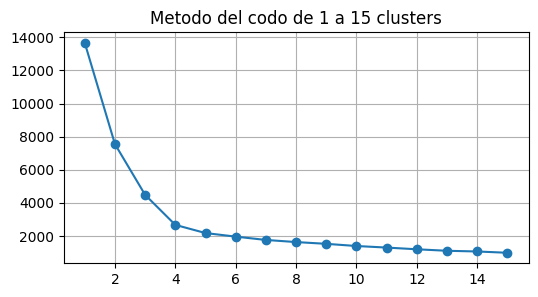

In [35]:
from sklearn.cluster import KMeans
sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(data_normalized)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(6, 3))
plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

In [36]:
kmeans_4 = KMeans(n_clusters=4).fit(data_normalized)

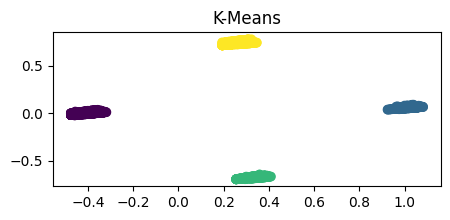

In [37]:
plt.figure(figsize=(5,2))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=kmeans_4.labels_)
plt.title("K-Means")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
print("Silhouette Score K-Means4\t", silhouette_score(data_normalized, kmeans_4.labels_))

Silhouette Score K-Means4	 0.6964360550248372


Se observan cuatro regiones bien separadas que el método K-means estima cada una como un cluster. Se observa un Silhouette relativamente alto, sin embargo es necesario validar si estos clusters tienen sentido viendo la distribucion de atributos dentro de ellos.

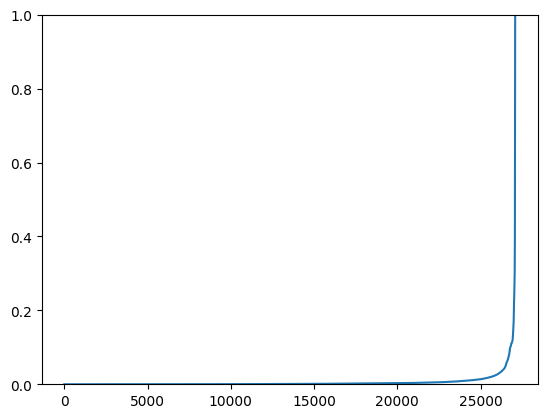

In [38]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=52).fit(data_normalized)
distances, indices = nbrs.kneighbors(data_normalized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=2, color='r', linestyle='--') #Ajuste el valor para y
plt.ylim(0, 1)
plt.plot(distances)

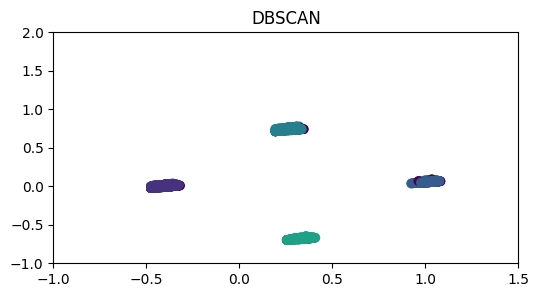

El numero de clusters es: 8


In [39]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


dbscan_1 = DBSCAN(eps=0.5, min_samples=28)
dbs_fit = dbscan_1.fit(data_normalized)

plt.figure(figsize=(6,3))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=dbs_fit.labels_)
plt.title("DBSCAN")
plt.xlim(-1, 1.5)
plt.ylim(-1, 2)
plt.show()
print('El numero de clusters es: ' + str(len(np.unique(dbs_fit.labels_))))

In [40]:
unique_elements, counts = np.unique(dbs_fit.labels_, return_counts=True)

print("Unique elements:", unique_elements)
print("Counts:", counts)

Unique elements: [-1  0  1  2  3  4  5  6]
Counts: [  180 15517  3636  3445  4136    97    32    32]


In [ ]:
from sklearn.metrics import silhouette_score
_filter_label = dbs_fit.labels_ >= 0
print("Silhouette Score DBSCAN\t", silhouette_score(data_normalized[_filter_label], dbs_fit.labels_[_filter_label]))

Silhouette Score DBSCAN	 0.7090775590751972


Se observa que DBSCAN obtiene 8 clusters, 4 más que K-means. DBSCAN arroja un Silhoutte score muy similar a K-means (solo 0.01 apróximadamente más que K-means)

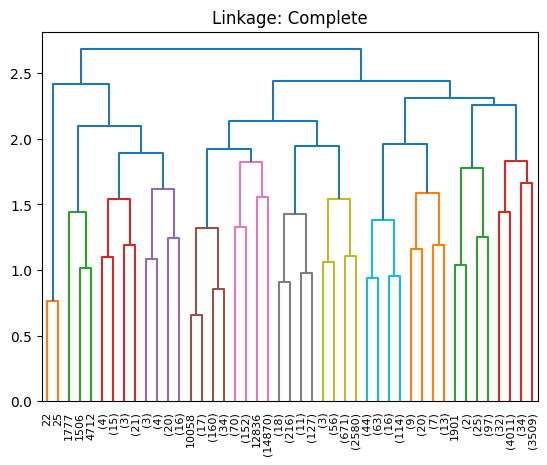

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage

complete = linkage(data_normalized, method="complete")
dendrogram(complete,p=5,truncate_mode='level')
plt.title("Linkage: Complete")
plt.axhline(y=700, color='r', linestyle='--')
plt.show()

In [42]:
from sklearn.cluster import AgglomerativeClustering
ward_5 = AgglomerativeClustering(n_clusters=5, linkage="complete").fit(data_normalized)
print('Agglomerative da ' + str(ward_5.n_clusters_) + 'clusters')

Agglomerative da 5clusters


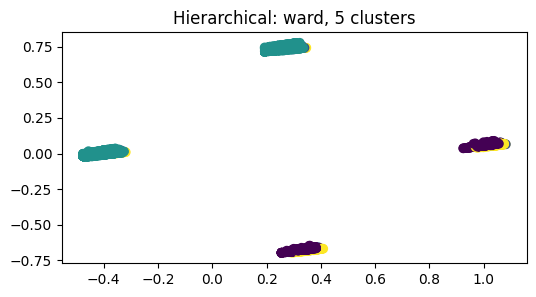

In [43]:
plt.figure(figsize=(6,3))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=ward_5.labels_)
plt.title("Hierarchical: ward, 5 clusters")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
print("Silhouette Score Agglomerative\t", silhouette_score(data_normalized, ward_5.labels_))

Silhouette Score Agglomerative	 0.5188431694752922


Con Agglomerative se obtienen 5 clusters y un Silhouette score menor que los otros métodos. Al momento de entregar este hito la revision y validacion de estos clusters está en proceso y se discutirá brevemente en el Hito 3.

# **Informe Grupo 6 Sección Hito 3 - "Steam Videogames Analysis"**

## Experimentos y resultados relevantes

### Análisis de clusters y clasificación
A continuación se presenta el análisis de cluster y su posterior clasificación, para ello en primer lugar se presentan los modelos de cluster:

1. Hierarchical: ward
2. DBSCAN
3. K-Means


Analisis de clusters obtenidos en el experimento preliminar (Ver todas las figuras en el Github en Hito3.ipynb)

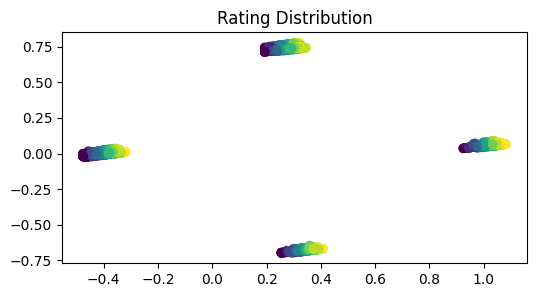

In [44]:
plt.figure(figsize=(6,3))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=df['rating_grouped'])
plt.title("Rating Distribution")
plt.show()

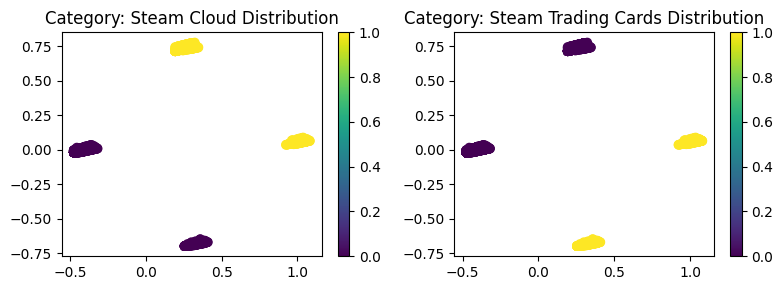

In [45]:
import matplotlib.pyplot as plt

# Assuming X_trans is your data and data_normalized is your DataFrame

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Adjust the figsize as needed

# Plot the first subplot
scatter1 = axes[0].scatter(X_trans[:, 0], X_trans[:, 1], c=data_normalized['category: Steam Cloud'])
axes[0].set_title("Category: Steam Cloud Distribution")
plt.colorbar(scatter1, ax=axes[0])

# Plot the second subplot
scatter2 = axes[1].scatter(X_trans[:, 0], X_trans[:, 1], c=data_normalized['category: Steam Trading Cards'])
axes[1].set_title("Category: Steam Trading Cards Distribution")
plt.colorbar(scatter2, ax=axes[1])

# Adjust layout
plt.tight_layout()

# Show the plot

Se observa que esta separación se debe lo más probablemente a las columnas 'category: Steam Trading Cards' y 'category: Steam Cloud' ya que solo tienen valores 0 y 1 generando esta separación de los datos. Vemos que por ejemplo el rating queda distribuido más o menos uniforme dentro de cada cluster por lo que no se está obteniendo información sobre si los juegos buenos se agrupan o no.

Para volver a hacer el clustering se borraron estas dos columnas de antes.

In [46]:
data_normalized_new = data_normalized.drop(columns=['category: Steam Trading Cards', 'category: Steam Cloud'])

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_trans_ = pca.fit_transform(data_normalized_new)

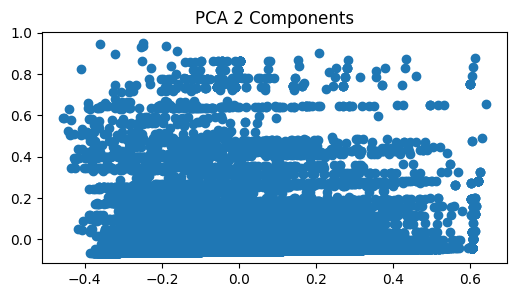

In [48]:
plt.figure(figsize=(6,3))
plt.scatter(X_trans_[:, 0], X_trans_[:, 1])
plt.title("PCA 2 Components")
plt.show()

Se observa que ahora la distribución de los datos es distinta, se aplica a continuación K-means de nuevo.

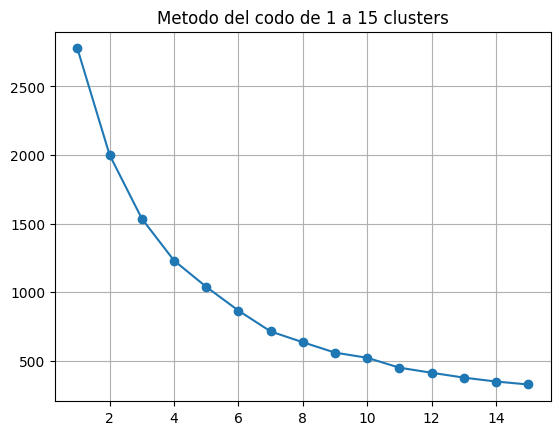

In [49]:
from sklearn.cluster import KMeans
sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(data_normalized_new)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

Si bien no se ve tan claro el 'codo' se elijen 10 clusters (Ver Anexo)

In [50]:
kmeans_10 = KMeans(n_clusters=10).fit(data_normalized_new)

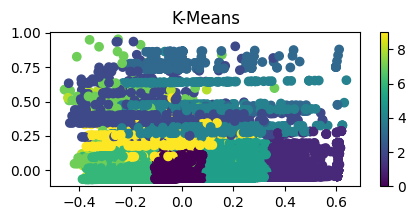

In [ ]:
plt.figure(figsize=(5,2))
plt.scatter(X_trans_[:, 0], X_trans_[:, 1], c=kmeans_10.labels_)
plt.title("K-Means")
plt.colorbar()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
print("Silhouette Score K-Means10\t", silhouette_score(data_normalized_new, kmeans_10.labels_))

Silhouette Score K-Means10	 0.4307147053951399


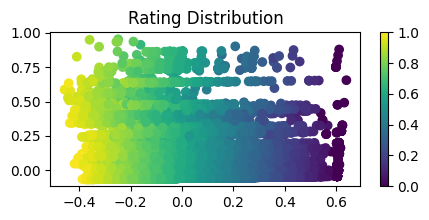

In [51]:
plt.figure(figsize=(5,2))
plt.scatter(X_trans_[:, 0], X_trans_[:, 1], c=data_normalized_new['rating'])
plt.title("Rating Distribution")
plt.colorbar()
plt.show()

De los dos gráficos anteriores se observa que hay algunos clusters que están asociados a un intervalo de rating definido, a continuación se muestra como se distribuyen los puntos con la columna 'Tag: Open World'.

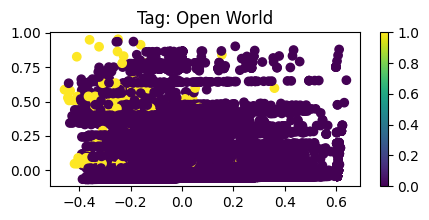

In [52]:
plt.figure(figsize=(5,2))
plt.scatter(X_trans_[:, 0], X_trans_[:, 1], c=data_normalized_new['tag: Open World'])
plt.title("Tag: Open World")
plt.colorbar()
plt.show()

Se observa en amarillo los punto que poseen este tag, se aprecia una leve tendencia de estos puntos de estar a la izqueirda en el gráfico, región asociada a un mayor rating. Hay que considerar que el Silhouette score de este Kmeans es menor que antes por lo que los clusters encontrados no tienen la misma calidad. A continuación se prueba DBSCAN con el dataset modificado.

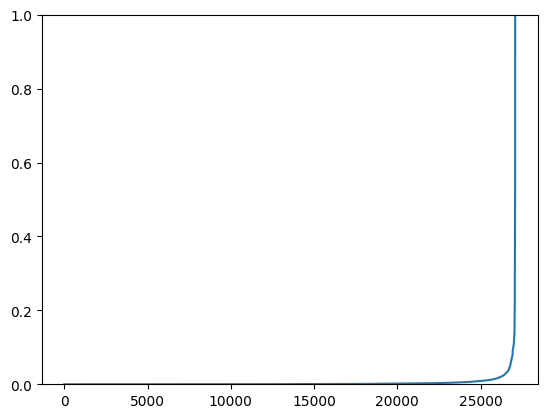

In [53]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=52).fit(data_normalized_new)
distances, indices = nbrs.kneighbors(data_normalized_new)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=2, color='r', linestyle='--') #Ajuste el valor para y
plt.ylim(0, 1)
plt.plot(distances)

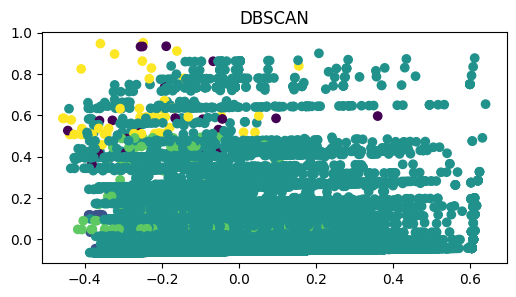

El numero de clusters es: 5


In [54]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


dbscan_1 = DBSCAN(eps=0.5, min_samples=26)
dbs_fit = dbscan_1.fit(data_normalized_new)

plt.figure(figsize=(6,3))
plt.scatter(X_trans_[:, 0], X_trans_[:, 1], c=dbs_fit.labels_)
plt.title("DBSCAN")
#plt.xlim(-1, 1.5)
#plt.ylim(-1, 2)
plt.show()
print('El numero de clusters es: ' + str(len(np.unique(dbs_fit.labels_))))

In [ ]:
unique_elements, counts = np.unique(dbs_fit.labels_, return_counts=True)

print("Unique elements:", unique_elements)
print("Counts:", counts)

Unique elements: [-1  0  1  2  3]
Counts: [   31    72 26737   186    49]


In [ ]:
from sklearn.metrics import silhouette_score
_filter_label = dbs_fit.labels_ >= 0
print("Silhouette Score DBSCAN\t", silhouette_score(data_normalized_new[_filter_label], dbs_fit.labels_[_filter_label]))

Silhouette Score DBSCAN	 0.6974958049367985


Se observa que DBSCAN obtuvo 5 clusters y un Silhoutte score similar al anterior

En esta ocación, se aplica en solo una instancia la selección de características, esta vez seleccionando 30 por posible variable objetivo, y seleccionando las varriables que se repitieran 6 o más veces.

In [55]:
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [56]:
df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

In [57]:
df = pre_process(df_steam)
df = pre_process1(df)
data = pre_process4(df)
data = pre_process5(data)

In [58]:
v_obj = ['achievements','positive_ratings','negative_ratings','average_playtime','median_playtime',
         'owners_lower','owners_upper','total_ratings','rating_ratio_grouped','rating_grouped',
         'achievements_count','positive_ratings_count', 'negative_ratings_count','average_playtime_count']
v_cat = ['appid','name','release_month','english', 'developer', 'publisher', 'required_age', 'price',
         'release_year','rating_ratio','rating']
# Variables platforms, categories y tags desacopladas
X = data.copy().drop(v_obj+v_cat,axis=1)

In [59]:
# Para cada variable posiblemente relacionada a la variable objetivo, se seleccionan
# las 20 mejores según SelectKBest.
atr = []
for i, var_obj in enumerate(v_obj):
  y = data.copy()[var_obj]
  X_fit = SelectKBest(chi2, k=30).fit(X, y)
  cols_idxs = X_fit.get_support(indices=True)
  atr = atr + list(X.columns[cols_idxs])

In [61]:
n_inst_atr = {element:atr.count(element) for element in set(atr) if atr.count(element) >= 6}
n_inst_atr = dict(sorted(n_inst_atr.items()))
n_inst_atr

{'category: In-App Purchases': 6,
 'category: Includes Source SDK': 6,
 'category: Multi-player': 6,
 'category: Steam Cloud': 6,
 'category: Steam Trading Cards': 6,
 'category: Steam Workshop': 7,
 'category: Valve Anti-Cheat enabled': 12,
 'publisher_count': 6,
 'tag: Crafting': 6,
 'tag: Dark Fantasy': 7,
 'tag: Lara Croft': 6,
 'tag: MMORPG': 8,
 'tag: MOBA': 8,
 'tag: Multiplayer': 6,
 'tag: Open World': 10,
 'temp0': 13,
 'temp1': 14}

In [62]:
df1 = pd.concat([data[v_obj+v_cat], data[n_inst_atr.keys()]],axis=1).copy()
data_new = pd.concat([data[v_obj], data[n_inst_atr.keys()]],axis=1).copy()
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_new)
data_normalized = pd.DataFrame(data=data_normalized,columns=data_new.columns)

Se obtienen 5 clusters de aplicar un clustering Linkage, con un umbral en 2.95 (Ver Anexo):

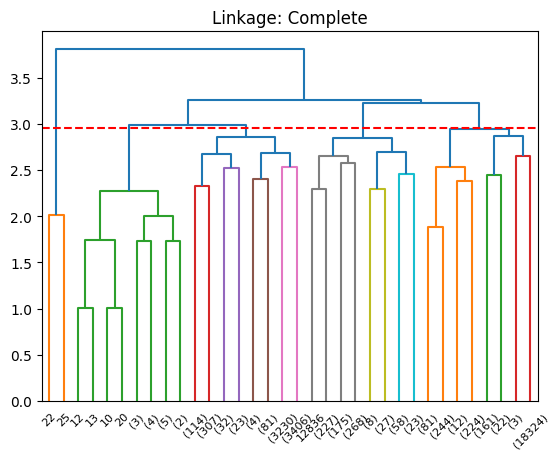

In [63]:
complete = linkage(data_normalized, method="complete")
dendrogram(complete,p=5,truncate_mode='level')
plt.title("Linkage: Complete")
plt.axhline(y=2.95, color='r', linestyle='--')
plt.show()

In [64]:
from scipy.cluster.hierarchy import fcluster
max_d = 2.95
clusters = fcluster(complete, max_d, criterion='distance')

Se plotean los resultados de los clusters obtenidos, cada una de las posibles variables objetivo y el índice de los datos para observar su distribución, ordenados por la variable objetivo respectiva. (Ver Anexo)

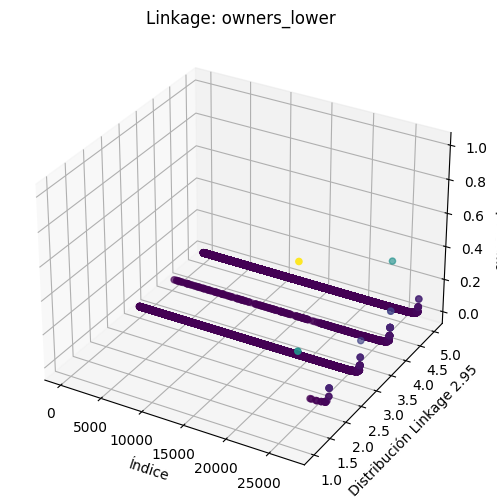

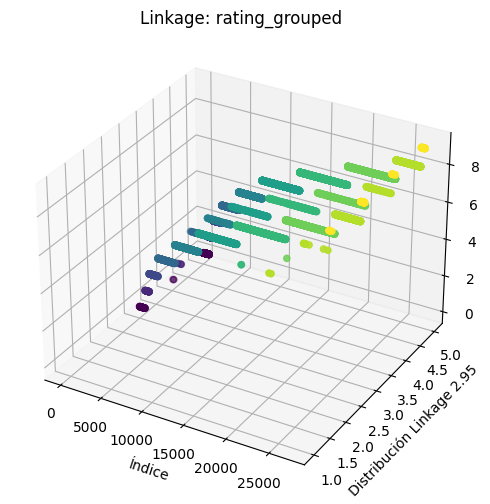

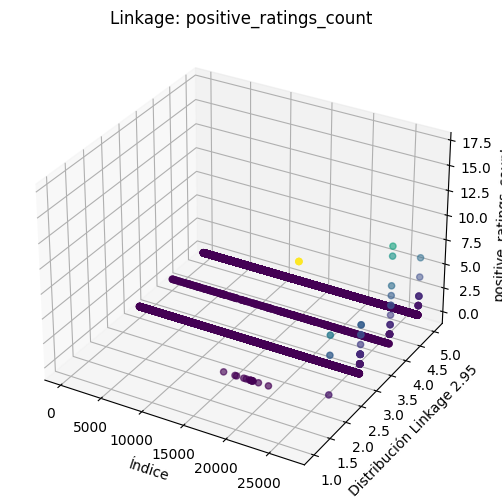

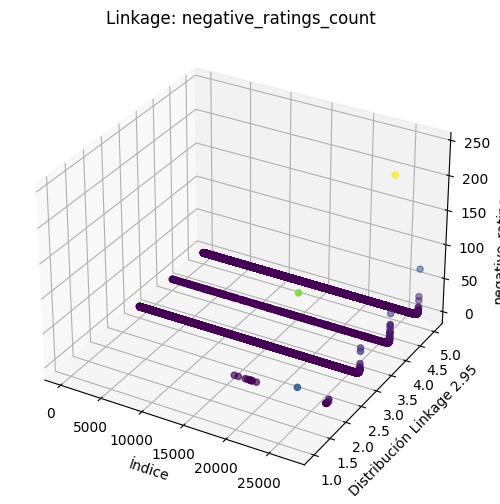

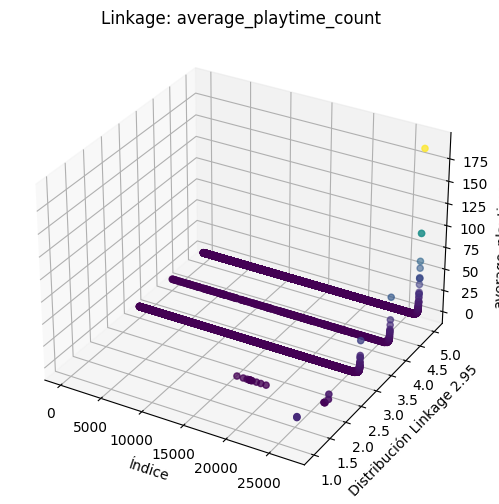

In [65]:
linkage_result = data_normalized.copy()
linkage_result['linkage_class'] = clusters

linkage_result1 = linkage_result.copy()
for atr in ['owners_lower', 'rating_grouped', 'positive_ratings_count', 'negative_ratings_count', 'average_playtime_count']:
  linkage_result1[atr] = data[atr]

for atr in ['owners_lower', 'rating_grouped', 'positive_ratings_count', 'negative_ratings_count', 'average_playtime_count']:
  df_temp = linkage_result1.sort_values([atr]).reset_index(drop=True).reset_index()[['index',atr,'linkage_class']].copy()
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(df_temp['index'], df_temp['linkage_class'], df_temp[atr], c=df_temp[atr], marker='o')
  ax.set_xlabel('Índice')
  ax.set_ylabel('Distribución Linkage 2.95')
  ax.set_zlabel(f'{atr}')
  plt.title(f"Linkage: {atr}")
  plt.show()

Se observa (Ver anexo) que no existe una correlación con ninguna de las posibles variables objetivo que podrían determinar si un juego es exitoso o no. la variable rating_grouped presenta un resultado interesante, pero se nota también que no hay agrupación por la los clusters linkage. Además, la variable rating_grouped es continua y está bien distribuida en los datos, al contrario de la mayoría, que presenta valores binarios.

In [66]:
ward = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(data_normalized)
pca = PCA(n_components=3)
X_trans = pca.fit_transform(data_normalized)

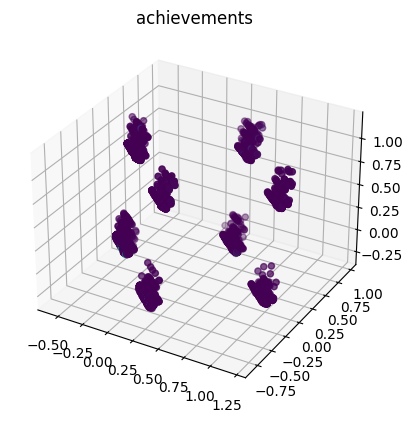

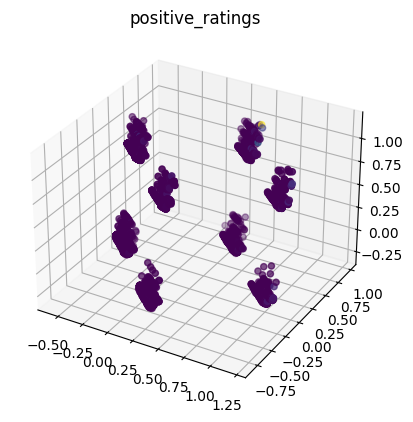

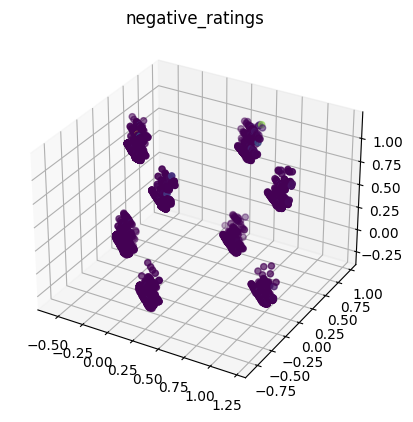

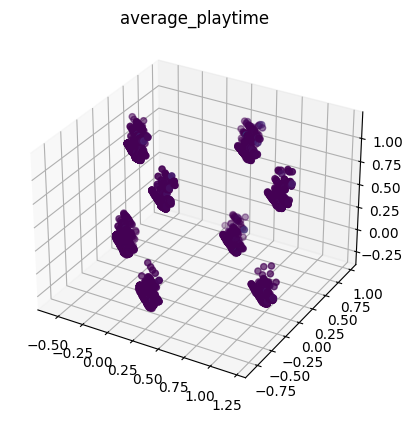

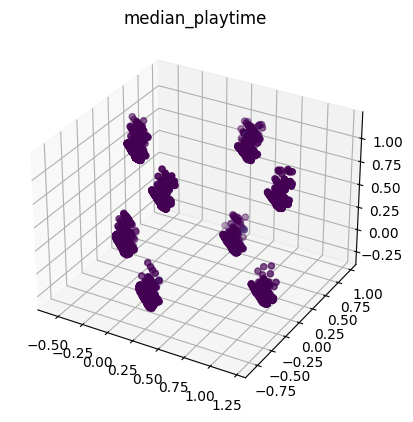

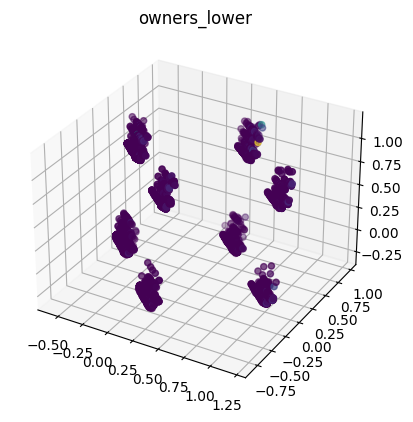

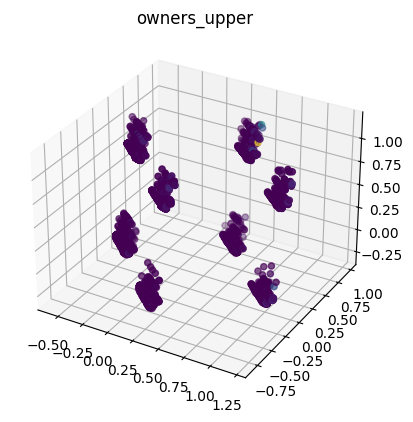

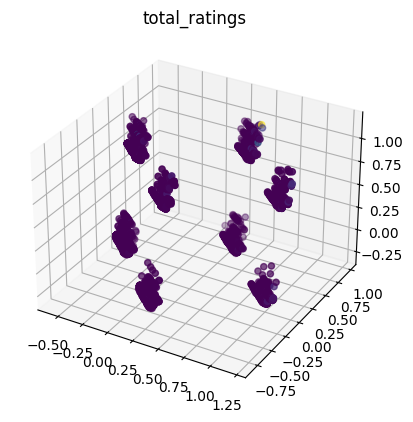

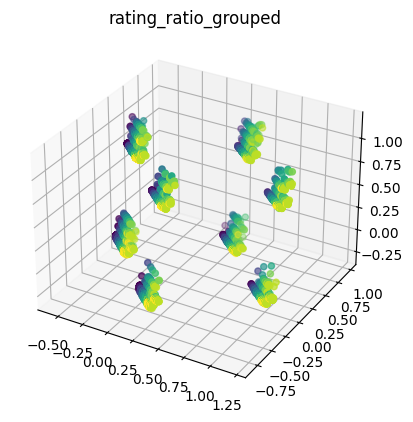

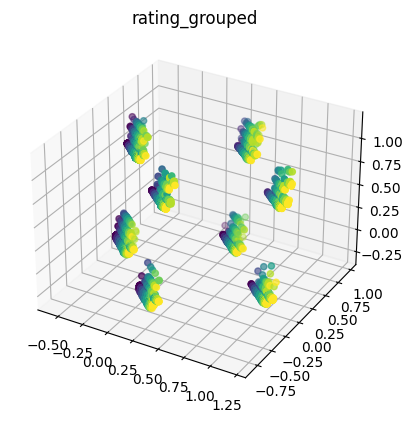

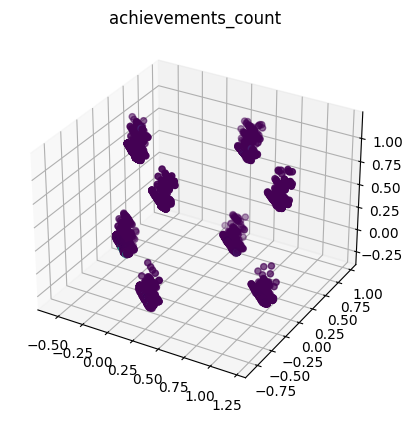

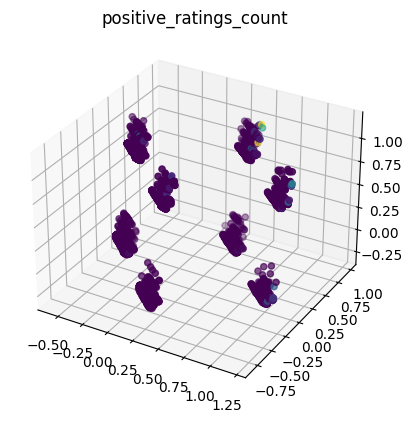

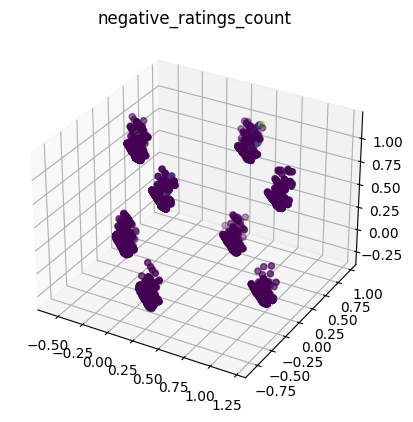

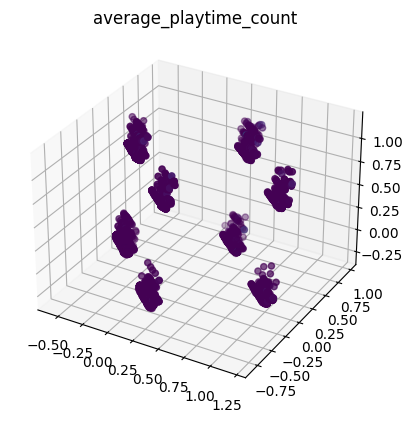

In [67]:
for obj in v_obj:
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(X_trans[:, 0], X_trans[:, 1], X_trans[:, 2], c=data_normalized[obj], marker='o')
  plt.title(obj)
  plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
print("Agglomerative\t", silhouette_score(data_normalized, ward.labels_))

Agglomerative	 0.36516010294600776


Como se observa en los gráficos (Ver Anexo) después de aplicar AgglomerativeClustering y PCA con 3 dimensiones, tampoco existe una relación entre los conjuntos proporcionados por agglomerative clustering(cuyo comportamiento se puede deber a la presencia de variables binarias) y alguna de las posibles variables que calificarían a un juego como exitoso. El Score Silhouette evidencia que sí existen agrupaciones, pero como ya mencionado, no tienen una base en el éxito de un juego.

### Regresión y Clasificación de las Descripciones de los juegos
A continuación se presentan los experimentos realizados para la regresión y clasificación de las descripciones de los juegos (Para ver todas las figuras, ie, matrices de confusion y resultados ver en el Github Steam_Regresiones.ipynb)

In [ ]:
# OPCIONAL:
# procesamiento opcional para las descripciones.

from bs4 import BeautifulSoup
import re

def process_html_text(html_text):
    # Use BeautifulSoup to parse the HTML
    soup = BeautifulSoup(html_text, 'html.parser')

    # Extract text content from HTML and convert to lowercase
    text_content = soup.get_text().lower()

    # Remove extra whitespaces and newlines
    text_content = re.sub(r'\s+', ' ', text_content).strip()

    return text_content

def preprocess_detailed_description(df):
  # limpiamos el texto html a texto normal
  df['filter_description'] = df['detailed_description'].apply(lambda x: process_html_text(x) if isinstance(x, str) else [])
  return df

def normalize_rating(df, attribute_name='rating'):
    # Min-Max normalization formula: (x - min) / (max - min)
    df[attribute_name] = (df[attribute_name] - df[attribute_name].min()) / (df[attribute_name].max() - df[attribute_name].min())

    return df


Se carga el dataset con las descripciones para luego aplicar clasificaciones de texto


In [ ]:
# Para el primer caso cargamos el dataset con las descriptions

# Load dataset with description
df_descriptions = pd.read_csv('/content/drive/My Drive/steam_description_data.csv')

# Add rating to df_description
df_descriptions = df_descriptions.merge(df_steam[['appid', 'rating','rating_label']], left_on='steam_appid', right_on='appid', how='left')

# Preprocess detailed_description
df_descriptions = preprocess_detailed_description(df_descriptions)

# Eliminate useless columns
columns_to_drop = ['about_the_game', 'short_description', 'appid']
df_descriptions = df_descriptions.drop(columns=columns_to_drop)
df_descriptions = df_descriptions.dropna(subset=['rating'])

df_descriptions.head()


También se tienen dos distintas opciones de vectorización:
1.   TF-IDF: Term frequency - Inverse document frequency, TF-IDF convierte el texto en vectores asignando pesos a las palabras basados en su frecuencia en un documento y en qué tan distintivas son en todo el corpus. Esto crea una representación vectorial que destaca la importancia relativa de las palabras en el documento.
2.   Glove2Vec: Es un algoritmo de Word Embeddings, Glove2Vec transforma el texto en vectores al asignar valores numéricos a las palabras según sus co-ocurrencias en el texto. Las relaciones semánticas entre palabras se capturan en un espacio vectorial, permitiendo representar el significado y la similitud entre palabras de manera más contextual.

In [ ]:
# USANDO TF-IDF VECTORIZATION
# Regresion con distintos modelos usando TF-IDF vectorization y la descripción de los juegos
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'rating' is the target column
X = df_descriptions['filter_description']
y = df_descriptions['rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization for descriptions
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.astype(str))
X_test_tfidf = tfidf_vectorizer.transform(X_test.astype(str))

# Train the models:

# Model 0: Dummy regression (use the mean rating for all games)
train_mean = np.mean(y_train)
predictions_dummy = np.ones(len(y_test)) * train_mean

# Model 1: Ridge regression
ridge_model = Ridge(alpha=1.5, random_state=241)
ridge_model.fit(X_train_tfidf, y_train)

# Make predictions for all models
predictions_ridge = ridge_model.predict(X_test_tfidf)

# Clip predictions to be at most 100
predictions_ridge = np.clip(predictions_ridge, None, 100)

# Evaluate the models
# MSE:
mse_dummy = mean_squared_error(y_test, predictions_dummy)
mse_ridge = mean_squared_error(y_test, predictions_ridge)

# MAE
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)

# R2:
r2_dummy = r2_score(y_test, predictions_dummy)
r2_ridge = r2_score(y_test, predictions_ridge)

print(f"Mean Squared Error Dummy: {mse_dummy}")
print(f"Mean Absolute Error Dummy: {mae_dummy}")
print(f"R-squared Dummy: {r2_dummy}")
print(" ")

print(f"Mean Squared Error Ridge: {mse_ridge}")
print(f"Mean Absolute Error Ridge: {mae_ridge}")
print(f"R-squared Ridge: {r2_ridge}")
print(" ")

- Mean Squared Error Dummy: 408.1963611286551
- Mean Absolute Error Dummy: 15.911209836494082
- R-squared Dummy: -0.00025024539053619677

- Mean Squared Error Ridge: 342.3836241623422
- Mean Absolute Error Ridge: 14.423524266764959
- R-squared Ridge: 0.16101823362863188

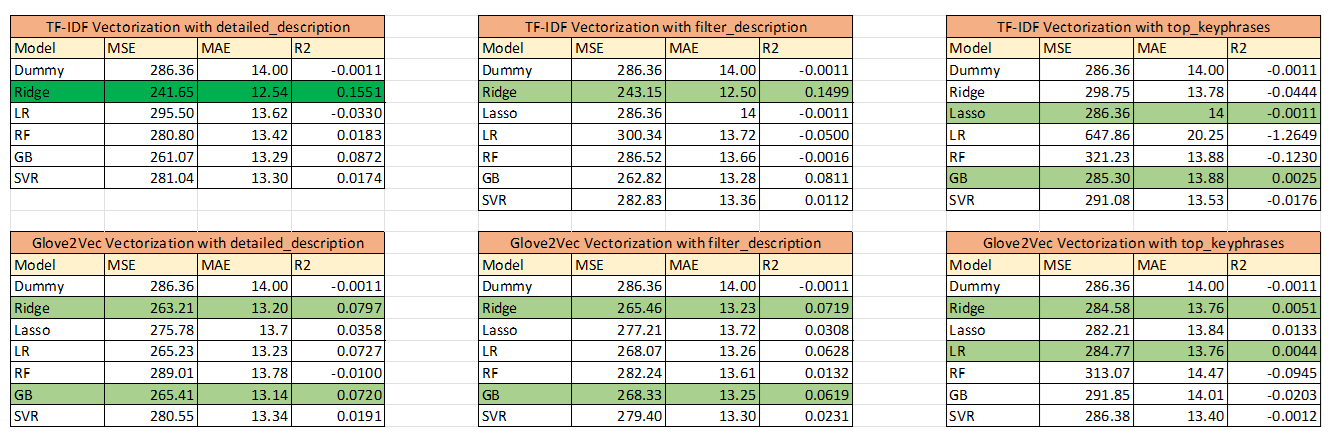

Se puede observar que los mejores resultados se obtuvieron con el modelo Ridge Regression, con TF-IDF y usando la detailed_description como input. Más detalles de los otros modelos de regresión se pueden encontrar en el github del proyecto. Lo útil de usar un modelo de regresión para predecir el rating es que podemos usarlo para rescatar los coeficientes más negativos o más positivos de la descripción de un juego, dicho de otra forma, las palabras en la descripción que más suben o bajan el rating de un juego, tomemos el ejemplo de la descripción del videojuego Skull Island, que fue noticia por su bajo rating (en Steam tiene un rating de 39.49), el modelo de ridge regression da los siguientes resultados

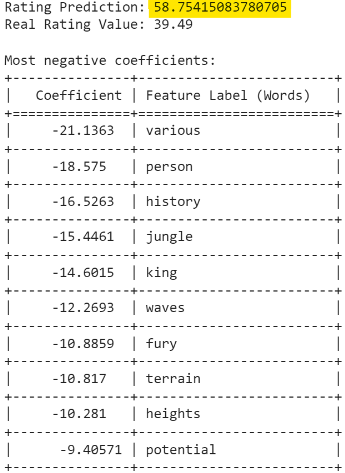

Se puede ver en este caso que la palabra "jungle" o "history" en la descripción de Skull Island afecta negativamente al rating, por lo cual se sugiere evitar hacer un juego con esas palabras en su descripción.

A continuación se presentan los distintos modelos de clasificadores, las clases creadas son "Muy Malo", "Malo", "Regular", "Bueno" y "Muy Bueno", que dividen al rating (0-100) en 5 partes: [0-20), [20-40), [40-60), [60-80) y [80-100] (Para ver todas las figuras ver en el Github Steam_Clasificadores.ipynb)

              precision    recall  f1-score   support

       Bueno       0.49      0.52      0.51      2181
        Malo       0.40      0.09      0.15       632
   Muy Bueno       0.40      0.03      0.06       749
    Muy Malo       0.00      0.00      0.00       139
     Regular       0.34      0.61      0.44      1490

    accuracy                           0.41      5191
   macro avg       0.33      0.25      0.23      5191
weighted avg       0.41      0.41      0.37      5191



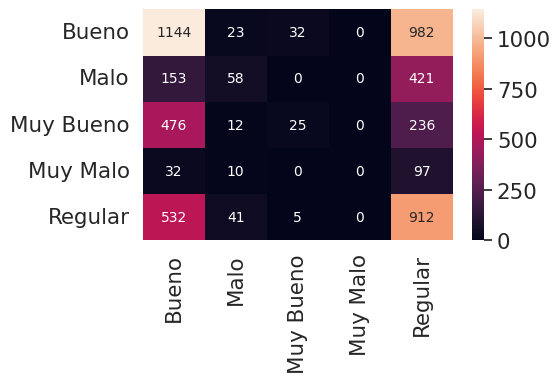

In [ ]:
# 1. CLASIFICACIÓN CON RIDGE REGRESSION:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

def calc_rating_label_array(ratings):
    """ Calculate rating labels based on an array of ratings. """
    # Divide el rango en 5 partes iguales
    bin_edges = [0, 20, 40, 60, 80, 100]
    labels = ["Muy Malo", "Malo", "Regular", "Bueno", "Muy Bueno"]
    # Asigna las etiquetas según el rango
    rating_labels = np.digitize(ratings, bins=bin_edges, right=True)
    # Ajusta el índice para obtener las etiquetas correctas del array 'labels'
    rating_labels -= 1
    # Convierte los índices en etiquetas
    rating_labels = [labels[i] for i in rating_labels]

    return rating_labels

# Create the confusion matrix
def plot_confussion_matrix(y_test, y_pred, class_names):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plot the confusion matrix
    plt.figure(figsize = (5,3))
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, fmt='.0f', annot_kws={"size": 10})  # font size
    plt.show()

ridge_labels = calc_rating_label_array(predictions_ridge)
test_labels = calc_rating_label_array(y_test)
dummy_labels = calc_rating_label_array(predictions_dummy)

class_names = ["Bueno" ,"Malo", "Muy Bueno","Muy Malo","Regular" ]
print(classification_report(test_labels, ridge_labels))
plot_confussion_matrix(test_labels, ridge_labels, class_names)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sn

y_1 = df_descriptions['rating_label']
X_train, X_test, y_1_train, y_1_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

In [ ]:
# 2. Clasificación con  Decision tree
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_tfidf, y_1_train)

# Make predictions on the test set
predictions_decision_tree = decision_tree_classifier.predict(X_test_tfidf)


# Evaluate the decision tree classifier
accuracy = accuracy_score(y_1_test, predictions_decision_tree)
print(f'Accuracy of Decision Tree Classifier: {accuracy}')

# Display the classification report
print('Classification Report:')
print(classification_report(y_1_test, predictions_decision_tree))

# Plot the confusion matrix
plot_confussion_matrix(y_1_test, predictions_decision_tree,class_names)


**Clasificación con  Decision tree**

En términos de precisión, el modelo logra un 44% para la clase "Bueno", indicando que el 44% de las instancias predichas como "Bueno" son realmente "Bueno". Sin embargo, los valores de precisión para las clases restantes son del 18%,10% y 31%, entonces se puede decir que el modelo tiene dificulatades para realizar predicciones precisas en las categorias de "Malo","Muy Malo","Muy Bueno"y "Regular".

En el caso de recall indica que el modelo identifica correctamente el 46% de todas las instancias reales de "Bueno",mientras que para la clase "Regular" identifica correctamente el 33% de la instancias. El recall es más bajo para
las otras clases, oscilando entre 7% y 17%.
F1-Score:

El F1-score es la media armónica de precision y recall. Se optienen valores similares que para recall y precisión, para las calses "Bueno" y "Regular" se obtienen valores altos como, 45% y 32% y para el resto de las clases se obtienen valores mas bajos entre 9% y 17%.

Accuracy es de aproximadamente de 33%, entonces el modelo acierta en aproximadamente el 33% de las predicciones en el conjunto de datos de prueba.

La precisión y el recall son bajos para varias clases, lo que indica que el modelo puede no estar generalizando bien a esas categorías específicas.
La accuracy es relativamente baja, lo que sugiere que el modelo no tiene un rendimiento robusto en la clasificación general.

In [ ]:
# 3. Clasificación con KNN

from sklearn.neighbors import KNeighborsClassifier

kkn_classifier = KNeighborsClassifier(n_neighbors=5)
kkn_classifier.fit(X_train_tfidf, y_1_train)

# Set up the k-NN classifier and make predictions
knn_classifier = KNeighborsClassifier(n_neighbors=10)  # Ajusta el número de vecinos según sea necesario
knn_classifier.fit(X_train_tfidf, y_1_train)
predictions_knn = knn_classifier.predict(X_test_tfidf)

# Evaluate the k-NN classifier
accuracy_knn = accuracy_score(y_1_test, predictions_knn)
print(f'Accuracy of k-NN Classifier: {accuracy_knn}')

# Display the classification report for k-NN
print('Classification Report for k-NN:')
print(classification_report(y_1_test, predictions_knn))

# Plot the confusion matrix for k-NN
plot_confussion_matrix(y_1_test, predictions_knn, class_names)

Para la mayoría de las clases, la precisión y el recall son bajos. Por ejemplo, para la clase "Bueno", la precisión es del 48%, pero el recall es muy bajo (1%). Esto sugiere que el modelo tiene dificultades para identificar correctamente esta clase.
La clase "Regular" tiene una precisión más alta (29%) y un recall muy alto (99%), lo que indica que el modelo es más efectivo para predecir esta clase en comparación con otras.

La precisión global es baja, con un 29.24%, lo que indica que el modelo acierta en alrededor del 29% de las predicciones en el conjunto de datos de prueba.

In [ ]:
# 4. Clasificación con Naive Bayes
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_1_train)


# Set up the Naive Bayes classifier and make predictions
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_1_train)
predictions_naive_bayes = naive_bayes_classifier.predict(X_test_tfidf)

# Evaluate the Naive Bayes classifier
accuracy_naive_bayes = accuracy_score(y_1_test, predictions_naive_bayes)
print(f'Accuracy of Naive Bayes Classifier: {accuracy_naive_bayes}')

# Display the classification report for Naive Bayes
print('Classification Report for Naive Bayes:')
print(classification_report(y_1_test, predictions_naive_bayes))

# Plot the confusion matrix for Naive Bayes
plot_confussion_matrix(y_1_test, predictions_naive_bayes, class_names)


**Clasificación con Naive Bayes**

Para la clase "Bueno", la precisión es del 42%, lo que indica que el 42% de las instancias predichas como "Bueno" son realmente "Bueno". Sin embargo, el recall es del 100%, sugiriendo que el modelo logra identificar todas las instancias reales de "Bueno". El F1-score es del 59%, indicando un equilibrio entre precisión y recall para esta clase.
Para otras clases como "Malo", "Muy Bueno", "Muy Malo", las métricas de precisión, recall y F1-score son extremadamente bajas. Esto sugiere que el modelo tiene dificultades para realizar predicciones precisas y no está capturando bien estas categorías. Para la clase "Regular", la precisión es del 75%, lo que indica que el 75% de las instancias predichas como "Regular" son realmente "Regular". Sin embargo el recall y f1-score son muy bajos, por tanto el modelo no está capturando bien esta categoría.


La exactitud del clasificador de Naive Bayes es del 42.13%. Esto significa que aproximadamente el 42% de las predicciones son correctas en el conjunto de datos de prueba.

In [ ]:
# 5. Clasificación con SVM
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=241)
svm_classifier.fit(X_train_tfidf, y_1_train)


# Set up the SVM classifier and make predictions
svm_classifier = SVC(kernel='linear', random_state=42)  # Puedes ajustar el kernel según sea necesario
svm_classifier.fit(X_train_tfidf, y_1_train)
predictions_svm = svm_classifier.predict(X_test_tfidf)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_1_test, predictions_svm)
print(f'Accuracy of SVM Classifier: {accuracy_svm}')

# Display the classification report for SVM
print('Classification Report for SVM:')
print(classification_report(y_1_test, predictions_svm))

# Plot the confusion matrix for SVM
plot_confussion_matrix(y_1_test, predictions_svm, class_names)

**Clasificación con SVM**

Para la clase "Bueno", la precisión es del 46%, indicando que el 46% de las instancias predichas como "Bueno" son realmente "Bueno". El recall es del 80%, sugiriendo que el modelo logra identificar el 80% de todas las instancias reales de "Bueno". El F1-score es del 58%, indicando un buen equilibrio entre precisión y recall para esta clase.
Para otras clases como "Malo", "Muy Bueno", "Muy Malo" y "Regular", las métricas de precisión, recall y F1-score son variadas. Se observa que el modelo tiene dificultades en particular para las clases minoritarias como "Muy Bueno" y "Muy Malo".

La clase "Bueno" tiene un soporte de 2181, lo que indica que hay muchas instancias de esta clase en el conjunto de datos. Para otras clases, el soporte es más bajo, destacando el desafío de la predicción en clases menos frecuentes.


La exactitud del clasificador SVM es del 43.09%, lo que significa que aproximadamente el 43% de las predicciones son correctas en el conjunto de datos de prueba.

## Conclusiones y futuras direcciones
Despues de evaluar  varios modelos de clasificación, se pudo saber que cada uno presenta sus propias fortalezas y debilidades en la predicción de diferentes clases. Considerando el equilibrio entre precisión, recall y F1-score, así como la capacidad de generalización,  la clasificacion con Ridge Regression es la mejor opcion, con una precisión del 49% para la clase "Bueno" y un recall del 52%, junto con resultados moderados para otras clases. En futuras direcciones, con más tiempo y conocimientos disponibles, se recomienda abordar el desafío del desequilibrio entre las clases mediante la implementación de técnicas de balanceo. La exploración de métodos como remuestreo, donde se ajusta la distribución de las clases, o la aplicación de estrategias especializadas como SMOTE, podría potenciar la capacidad del modelo para predecir con precisión las categorías minoritarias. Estas técnicas ofrecen oportunidades valiosas para mejorar la robustez y la eficacia general del modelo de clasificación.

El modelo de regresión permite identificar los coeficientes asociados a palabras de la descripción que “nerfean” el rating del juego.

Del clustering si bien se encontró que un tipo de juego tiene asociado un mayor rating, los otros modelos no dan resultados que permitan identificar fácilmente esta tendencia ni tampoco se puede extender a otras caracteristícas. Es por esto que no se le pudieron asignar nombres a los clusters ya que no hubo atributos que los identificaran claramente. Por lo que no se pudieron encontrar patrones que permitan identificar a un juego bueno. Uno de los mayores problemas que surgieron fue la alta dimesionalidad de los datos, reducir aún más la dimesionalidad puede que mejore los resultados obtenidos.

## Contribuciones de los integrantes


* Cristóbal Braga: Clustering(Kmeans/DSCAN)/Informe/Presentación
* Isabel Marx: Preprocesamiento/Clustering(Aggloremative)/Informe/Presentación
* Iván Salas: Preprocesamiento/Regresión/Informe/Presentación
* Manuel Ortiz: Preprocesamiento/Clustering/Informe/Presentación
* Sofia Medina: Preprocesamiento/Clasificación/Informe/Presentación

